In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xlrd

In [2]:
projects = pd.read_excel('/Users/claudio/Downloads/IDB-Projects (2).xls', header=1)

In [3]:
projects.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3255 entries, 0 to 3254
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Project number           3255 non-null   object
 1   Project title            3255 non-null   object
 2   Project description      3060 non-null   object
 3   Project Operation type   3255 non-null   object
 4   Project Country          3255 non-null   object
 5   Project Sector           3255 non-null   object
 6   Approval Amount (US $M)  3255 non-null   int64 
 7   Approval Date            3232 non-null   object
 8   Status                   3255 non-null   object
 9   ESG Classification       1117 non-null   object
dtypes: int64(1), object(9)
memory usage: 254.4+ KB


In [4]:
book = xlrd.open_workbook('/Users/claudio/Downloads/IDB-Projects (2).xls', formatting_info=True)
sh = book.sheet_by_index(0)
urls = [v.url_or_path for v in sh.hyperlink_list]

In [5]:
# Add url columns if len is equal
if len(urls) == projects.shape[0]:
    projects['urls'] = urls

In [6]:
# ID Integrity
projects['Project number'].unique().shape

(3255,)

In [7]:
# Duplicated project titles
projects['Project title'].duplicated(keep=False).sum()

277

In [8]:
# Number of duplicated project descriptions
projects['Project description'].value_counts().head(5).to_frame()

,Project description
EN,1171
Financing of activities that will support the modernization and strengthening of the beneficiary countries¿ technical and managerial capacity and that will consolidate the institutional sustainability of public agencies to promote more effective use of Bank project funds.,16
"To train public officials of member countries of the Council of Ministers of Finance of Central America, Panama, and Dominican Republic (COSEFIN) in Electronic Invoicing and Fiscal Risk. To meet this objective, we will finance the participation of public officials in two activities: (i) a seminar organized by the Mexican Tax Administration Service (SAT) on the successful experience of electronic invoicing models and risk analysis (domestic taxes and customs) and (ii) the Network of Experts on Fiscal Risk Management of the Inter-American Center on Fiscal Administrations (CIAT), to be held in Guatemala. Both activities are jointly coordinated with CIAT and German Cooperation (GIZ), and are carried out within the joint technical assistance framework with the IDB.",8
"Special action plan for IDB Category C and D countries to help improve country capacity to identify, prepare and execute Bank-financed projects.",5
"The objective of this TC is to continue supporting borrowing member countries in their efforts to strengthen public procurement and financial management systems to increase the capacity of their national institutions and improve service delivery and policy implementation, by: 1) supporting the adoption and implementation of international standards and/or narrowing the gaps with good practices; and 2) transferring knowledge and supporting government-to-government cooperation within the region to exchange good practices and lessons learned from other countries.",4


In [9]:
# Proyectos por tipo de operacion
projects['Project Operation type'].value_counts()

Technical Cooperation      2635
Loan Operation              595
Grant Financing Product      15
Container                     9
Investment Grants             1
Name: Project Operation type, dtype: int64

In [10]:
projects['Project Country'].value_counts()

Regional               758
Guatemala              167
Honduras               164
Paraguay               158
Ecuador                157
Colombia               155
Brazil                 152
Bolivia                145
Nicaragua              143
Peru                   128
El Salvador            126
Dominican Republic     114
Argentina              100
Uruguay                 92
Chile                   75
Costa Rica              74
Mexico                  73
Panama                  70
Haiti                   66
Jamaica                 63
Venezuela               54
Guyana                  50
Suriname                48
Trinidad and Tobago     37
Barbados                32
Belize                  31
Bahamas                 23
Name: Project Country, dtype: int64

In [11]:
amount_millions = projects['Approval Amount (US $M)'] / 1000000

In [12]:
amount_millions.describe(percentiles=[.25, .5, .75, .8, .85, .9, .95, .98, .99]).round(2)

count    3255.00
mean       17.81
std        83.88
min         0.00
25%         0.06
50%         0.20
75%         0.90
80%         1.50
85%         5.78
90%        22.88
95%        80.45
98%       298.80
99%       400.00
max      2500.00
Name: Approval Amount (US $M), dtype: float64

In [13]:
# Filter extreme values
upper_limit = amount_millions.mean() + (amount_millions.std() * 3)
lower_limit = amount_millions.mean() - (amount_millions.std() * 3)

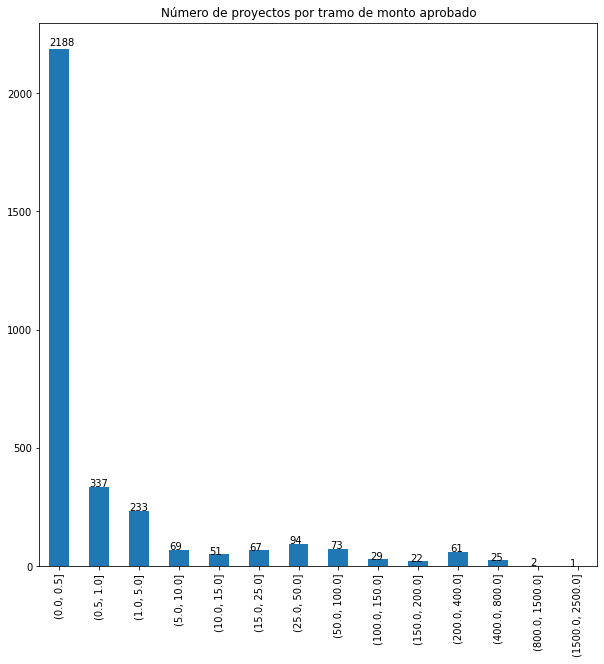

In [14]:
# Visualize binarized approved amount
bins = [0, .5, 1, 5, 10, 15, 25, 50, 100, 150, 200, 400, 800, 1500, 2500]
amount_bins = pd.cut(amount_millions, bins=bins).value_counts().sort_index()
ax = amount_bins.plot.bar(figsize=(10,10))
ax.set_title('Número de proyectos por tramo de monto aprobado')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

In [15]:
date = pd.to_datetime(projects['Approval Date'])

In [16]:
projects['approval_datetime'] = date
projects['approval_year'] = date.dt.year

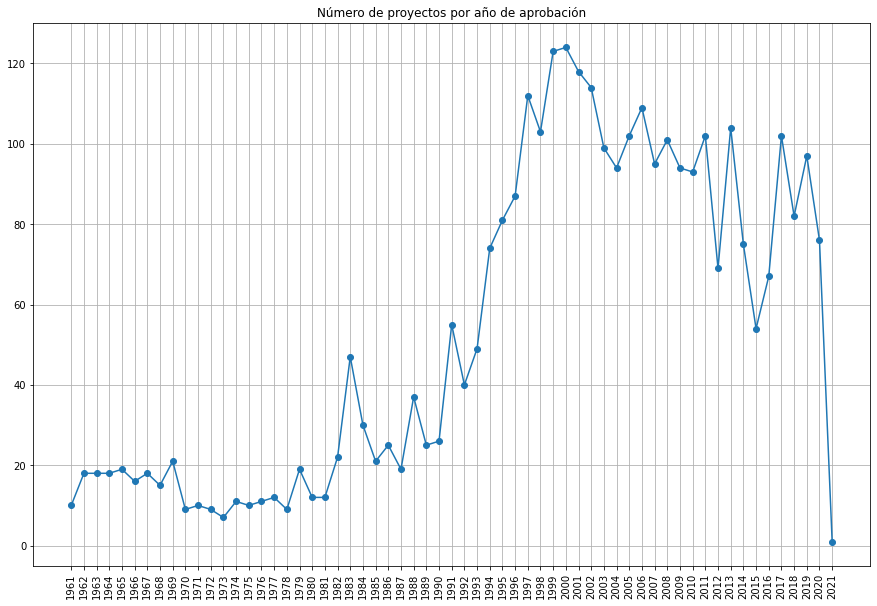

In [17]:
projects_x_year = date.dt.year.value_counts().sort_index()
ax = projects_x_year.plot.line(figsize=(15,10), marker='o', rot=90)
ax.set_xticks(projects_x_year.index)
ax.set_title('Número de proyectos por año de aprobación')
plt.grid()
plt.show()

In [673]:
projects_x_year.iloc[-14]

101

In [671]:
projects_x_year.iloc[-2]

76

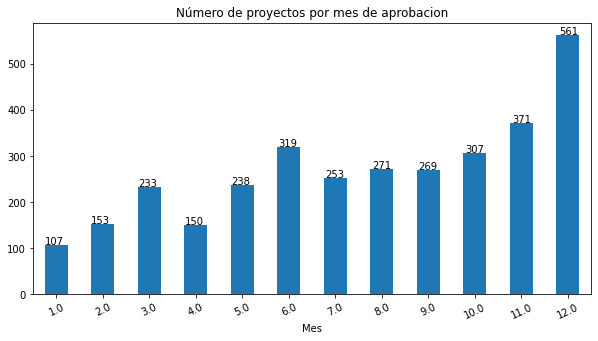

In [669]:
ax = date.dt.month.value_counts().sort_index().plot.bar(figsize=(10,5), rot=25)
ax.set_title('Número de proyectos por mes de aprobacion')
ax.set_xlabel('Mes')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.show()

In [19]:
projects['Status'].value_counts()

Closed            2790
Implementation     333
Cancelled          109
Preparation         23
Name: Status, dtype: int64

In [20]:
projects['ESG Classification'].value_counts()

C         911
B13       107
C(R)       55
B13(R)     23
B          14
B(R)        6
A           1
Name: ESG Classification, dtype: int64

In [22]:
projects['Status'].unique()

array(['Preparation', 'Implementation', 'Closed', 'Cancelled'],
      dtype=object)

In [28]:
old_cols = projects.columns
projects.columns = [col.lower().replace('project ', '').replace(' ', '_') for col in old_cols]

>WARNING:  EZSHARE-1174637139-2757.txt - inconsistencia en tabla de resumen (SO)

In [493]:
def get_selected_option(content, indicator_ix, size):
    try:
        table = content[indicator_ix:indicator_ix+size]
        opt = [el.strip() for el in table if re.search('^\[\s*(X|x)' , el)]
        return opt
    except Exception as e:
        print('Error:', e)
        return []

In [510]:
def get_product_info(content, start_ix, end_ix):
    '''
    PROGRESO EN LA IMPLEMENTACION (PI)
    - Componentes (Productos) Indicadores Claves del Producto
    -- Explique brevemente diferencias entre los productos planeados y actuales (sin aplica).
    -- Reestructuración. Indique si este componente del proyecto ha sido reestructurado (fecha aprobación Gerente)(si
    aplica). Describir brevemente las consecuencias de estos cambios.
    
    '''
    try:
        progress_imp_table = content[start_ix:end_ix]

        products_indexs = [i for i, line in enumerate(progress_imp_table) if re.search(r'Componentes \(Productos\)', line) ]
        print('# of products ixs', len(products_indexs))
        products_indexs.append(-1)
        print('indexes:', products_indexs)

        diffs = []
        restruct = []
        for ix in range(len(products_indexs)-1):
            product = progress_imp_table[products_indexs[ix]:products_indexs[ix+1]]

            diffs_ix = [i for i, line in enumerate(product) if re.search(f'Explique brevemente diferencias entre los productos planeados y actuales', line)][0]
            restruct_ix = [i for i, line in enumerate(product) if re.search('Re+structuraci(ó|o)n', line)][0]
            diff_section = ' '.join(product[diffs_ix+1:restruct_ix])
            restruct_section = ' '.join(product[restruct_ix+2:-13])

            diffs.append(diff_section)
            restruct.append(restruct_section)

        return diffs, restruct
    except Exception as e:
        print('Error:', e)
        return [], []

In [556]:
def process_pdf(fn):
    print('Filename:', fn)
    
    with  open(f'outputs/pdf2txt/{fn}', 'r') as f:
        content = f.readlines()
    
    ixs = [[j for j, line in enumerate(content) if re.search(kw, line)][0]
     for i, kw in enumerate(keywords_r)]
    
    proj_id = content[ixs[0]].split(': ')[1].strip('\n')
    
    summary_performance = get_selected_option(content, ixs[1], 35)
    design_quality = get_selected_option(content, ixs[2], 13)[0]
    counterpart_perf = get_selected_option(content, ixs[6], 10)[0]
    bank_perf = get_selected_option(content, ixs[7], 16)[0]
    diffs, restruct = get_product_info(content, ixs[4], ixs[5])
    
    print('-----')
    return {'fn': fn,
            'proj_id': proj_id,
            'sum_perf': summary_performance,
            'design_qa': design_quality, 
            'cp_perf': counterpart_perf,
            'bank_perf': bank_perf,
            'diffs': diffs,
            'restruct': restruct}

In [547]:
keywords_r = [f'Nú|umero de Proyecto:',
            r'Resumen de la Clasificaci(ó|o)n de Desempeño',
            r'^Revisi(ó|o)n de la Calidad del Diseño',
            r'Desarrollo Clasificaci(ó|o)n',
            r'PROGRESO EN LA IMPLEMENTACI(O|Ó)N',
            r'Costos del (Proyecto|Programa)',
            r'Clasificaci(ó|o)n del Desempeño del Prestatario/Agencia Ejecutora',
            r'Clasificaci(ó|o)n del Desempeño del Banco',
            r'Clasificaci(ó|o)n de Sostenibilidad']

In [558]:
filenames = [f for f in os.listdir('outputs/pdf2txt/') if f.endswith('.txt')]

In [559]:
project_data = [process_pdf(fn) for fn in filenames]

Filename: EZSHARE-1191130075-3810.txt
# of products ixs 1
indexes: [2, -1]
-----
Filename: EZSHARE-196640690-2509.txt
# of products ixs 0
indexes: [-1]
-----
Filename: EZSHARE-1174637139-2757.txt
# of products ixs 2
indexes: [105, 244, -1]
-----
Filename: EZSHARE-196640690-2352.txt
# of products ixs 0
indexes: [-1]
-----
Filename: EZSHARE-2072960787-6337.txt
# of products ixs 3
indexes: [179, 273, 341, -1]
-----
Filename: EZSHARE-1444041322-2249.txt
# of products ixs 3
indexes: [2, 178, 411, -1]
-----


In [560]:
for proj in project_data:
    section = ['OD', 'PI', 'SO']
    for i, val in enumerate(proj['sum_perf']):
        proj[section[i]] = val

In [561]:
project_df = pd.DataFrame.from_records(project_data)

In [562]:
project_df.columns

Index(['fn', 'proj_id', 'sum_perf', 'design_qa', 'cp_perf', 'bank_perf',
       'diffs', 'restruct', 'OD', 'PI', 'SO'],
      dtype='object')

In [687]:
project_df[['proj_id', 'design_qa']]

,proj_id,design_qa
0,AR-L1002,[X ] Menos que Satisfactorio (MS)
1,AR L1001,[x] Plenamente Satisfactorio (PS)
2,AR-L1022,[X] Muy Satisfactorio (MS)
3,AR L1001,[x] Plenamente Satisfactorio (PS)
4,AR -L1004,[X ] Muy Satisfactorio (MS)
5,AR – L1012,[x] Plenamente


In [684]:
project_df[['proj_id', 'OD', 'PI', 'SO', 'cp_perf', 'bank_perf']]

,proj_id,OD,PI,SO,cp_perf,bank_perf
0,AR-L1002,[X] Probable (S),[X] Satisfactorio (S),[X] Satisfactorio (S),[X] Satisfactorio (S),[X ] Satisfactorio (S)
1,AR L1001,[ x ] Probable (P),[ x ] Satisfactorio (S),[ x ] Satisfactorio (S),[ x ] Satisfactorio (S),[ x ] Satisfactorio (S)
2,AR-L1022,[X] Muy Probable(MP),[X] Muy Satisfactorio(MS),[X] Muy Satisfactorio (MS),[X] Muy Satisfactorio (MS),[X] Satisfactorio (S)
3,AR L1001,[ x ] Probable (P),[ x ] Satisfactorio (S),[ x ] Satisfactorio (S),[ x ] Satisfactorio (S),[ x ] Satisfactorio (S)
4,AR -L1004,[X] Probable (S),[X] Satisfactorio (S),[X] Satisfactorio (S),[X] Satisfactorio (S),[X] Muy Satisfactorio (MS)
5,AR – L1012,[ x] Probable (S),[x ] Satisfactorio (S),[ x] Satisfactorio (S),[X ] Satisfactorio (S),[ X] Satisfactorio (S)


In [588]:
projects[projects['number'].str.startswith('AR-L100')]

,number,title,description,operation_type,country,sector,approval_amount_(us_$m),approval_date,status,esg_classification,urls,approval_datetime,approval_year
1332,AR-L1009,Public Finance Management Sector,The project would have three components:\n1. P...,Loan Operation,Argentina,REFORM / MODERNIZATION OF THE STATE,500000000,01-Mar-2006,Closed,NaN,https://www.iadb.org/project/AR-L1009,2006-03-01,2006.0
1456,AR-L1008,Institutional Strengthening Program for the Na...,The general objective of the program is to sup...,Loan Operation,Argentina,REFORM / MODERNIZATION OF THE STATE,4800000,08-Dec-2004,Closed,B13(R),https://www.iadb.org/project/AR-L1008,2004-12-08,2004.0
1467,AR-L1002,Inst Improvement Prog for Productive Sector & ...,The general objective of the program is to con...,Loan Operation,Argentina,REFORM / MODERNIZATION OF THE STATE,18000000,17-Nov-2004,Closed,B13(R),https://www.iadb.org/project/AR-L1002,2004-11-17,2004.0
1486,AR-L1001,Strengthening of the Economic Policy Secretariat,The project objective is to contribute to the ...,Loan Operation,Argentina,REFORM / MODERNIZATION OF THE STATE,4800000,08-Sep-2004,Closed,C(R),https://www.iadb.org/project/AR-L1001,2004-09-08,2004.0


In [689]:
projects.columns

Index(['number', 'title', 'description', 'operation_type', 'country', 'sector',
       'approval_amount_(us_$m)', 'approval_date', 'status',
       'esg_classification', 'urls', 'approval_datetime', 'approval_year'],
      dtype='object')

In [790]:
projects[projects['number'].str.startswith('AR-L100')]

,number,title,description,operation_type,country,sector,approval_amount_(us_$m),approval_date,status,esg_classification,urls,approval_datetime,approval_year
1332,AR-L1009,Public Finance Management Sector,The project would have three components:\n1. P...,Loan Operation,Argentina,REFORM / MODERNIZATION OF THE STATE,500000000,01-Mar-2006,Closed,NaN,https://www.iadb.org/project/AR-L1009,2006-03-01,2006.0
1456,AR-L1008,Institutional Strengthening Program for the Na...,The general objective of the program is to sup...,Loan Operation,Argentina,REFORM / MODERNIZATION OF THE STATE,4800000,08-Dec-2004,Closed,B13(R),https://www.iadb.org/project/AR-L1008,2004-12-08,2004.0
1467,AR-L1002,Inst Improvement Prog for Productive Sector & ...,The general objective of the program is to con...,Loan Operation,Argentina,REFORM / MODERNIZATION OF THE STATE,18000000,17-Nov-2004,Closed,B13(R),https://www.iadb.org/project/AR-L1002,2004-11-17,2004.0
1486,AR-L1001,Strengthening of the Economic Policy Secretariat,The project objective is to contribute to the ...,Loan Operation,Argentina,REFORM / MODERNIZATION OF THE STATE,4800000,08-Sep-2004,Closed,C(R),https://www.iadb.org/project/AR-L1001,2004-09-08,2004.0


In [639]:
corrupt = pd.read_csv('inputs/world_bank/corrupt.csv', skiprows=3)

In [640]:
corrupt.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
0,Aruba,ABW,"Calificación de transparencia, responsabilidad...",IQ.CPA.TRAN.XQ,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afganistán,AFG,"Calificación de transparencia, responsabilidad...",IQ.CPA.TRAN.XQ,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,NaN
2,Angola,AGO,"Calificación de transparencia, responsabilidad...",IQ.CPA.TRAN.XQ,NaN,NaN,NaN,NaN,NaN,NaN,...,2.5,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Albania,ALB,"Calificación de transparencia, responsabilidad...",IQ.CPA.TRAN.XQ,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Andorra,AND,"Calificación de transparencia, responsabilidad...",IQ.CPA.TRAN.XQ,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [641]:
gini = pd.read_csv('inputs/world_bank/gini.csv', skiprows=3)

In [642]:
gini.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
0,Aruba,ABW,Índice de Gini,SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afganistán,AFG,Índice de Gini,SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Angola,AGO,Índice de Gini,SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,51.3,NaN,NaN,NaN
3,Albania,ALB,Índice de Gini,SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,29.0,NaN,34.6,32.9,33.7,33.2,NaN,NaN,NaN,NaN
4,Andorra,AND,Índice de Gini,SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [644]:
pbi = pd.read_csv('inputs/world_bank/pbi.csv', skiprows=3)

In [646]:
pbi.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
0,Aruba,ABW,PIB (US$ a precios actuales),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,2.534637e+09,2.701676e+09,2.765363e+09,2.919553e+09,2.965922e+09,3.056425e+09,NaN,NaN,NaN,NaN
1,Afganistán,AFG,PIB (US$ a precios actuales),NY.GDP.MKTP.CD,5.377778e+08,5.488889e+08,5.466667e+08,7.511112e+08,8.000000e+08,1.006667e+09,...,2.000160e+10,2.056107e+10,2.048489e+10,1.990711e+10,1.801775e+10,1.886995e+10,1.835388e+10,1.929110e+10,NaN,NaN
2,Angola,AGO,PIB (US$ a precios actuales),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,1.280529e+11,1.367099e+11,1.457122e+11,1.161936e+11,1.011239e+11,1.221238e+11,1.013532e+11,8.881570e+10,NaN,NaN
3,Albania,ALB,PIB (US$ a precios actuales),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,1.231983e+10,1.277622e+10,1.322814e+10,1.138685e+10,1.186120e+10,1.301969e+10,1.514702e+10,1.527918e+10,NaN,NaN
4,Andorra,AND,PIB (US$ a precios actuales),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,3.188809e+09,3.193704e+09,3.271808e+09,2.789870e+09,2.896679e+09,3.000181e+09,3.218316e+09,3.154058e+09,NaN,NaN


In [586]:
country_metadata = pd.read_csv('inputs/world_bank/country_metadata.csv')

In [587]:
country_metadata

,Country Name,Country Code,Region,Income_Group,Unnamed: 4
0,Aruba,ABW,NaN,Ingreso alto,NaN
1,Afganistán,AFG,Asia meridional,Países de ingreso bajo,NaN
2,Angola,AGO,África al sur del Sahara (excluido altos ingre...,Países de ingreso mediano bajo,NaN
3,Albania,ALB,Europa y Asia central (excluido altos ingresos),Ingreso mediano alto,NaN
4,Andorra,AND,NaN,Ingreso alto,NaN
...,...,...,...,...,...
259,Kosovo,XKX,Europa y Asia central (excluido altos ingresos),Ingreso mediano alto,NaN
260,"Yemen, Rep. del",YEM,Oriente Medio y Norte de África (excluido alto...,Países de ingreso bajo,NaN
261,Sudáfrica,ZAF,África al sur del Sahara (excluido altos ingre...,Ingreso mediano alto,NaN
262,Zambia,ZMB,África al sur del Sahara (excluido altos ingre...,Países de ingreso mediano bajo,NaN


In [762]:
projects_income = projects.merge(country_metadata[['Country Name', 'Income_Group']], left_on='country',
               right_on='Country Name')

In [763]:
projects_income['Income_Group'].unique()

array(['Países de ingreso mediano bajo', 'Ingreso alto',
       'Ingreso mediano alto'], dtype=object)

In [764]:
projects_income['Income_Group'] = projects_income['Income_Group'].replace({'Países de ingreso mediano bajo': 'Medio bajo',
'Ingreso alto': 'Alto',
'Ingreso mediano alto': 'Medio alto'})

In [765]:
projects_income['Income_Group'].value_counts()[['Medio bajo', 'Medio alto', 'Alto']]

Medio bajo     578
Medio alto    1026
Alto           222
Name: Income_Group, dtype: int64

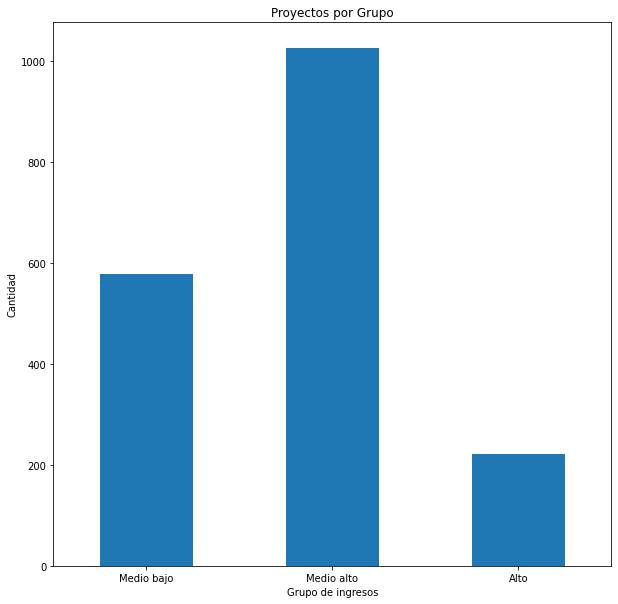

In [766]:
ax = projects_income['Income_Group'].value_counts()[['Medio bajo', 'Medio alto', 'Alto']].plot.bar(rot=0, figsize=(10,10))
ax.set_ylabel('Cantidad')
ax.set_xlabel('Grupo de ingresos')
plt.title('Proyectos por Grupo')
plt.show()

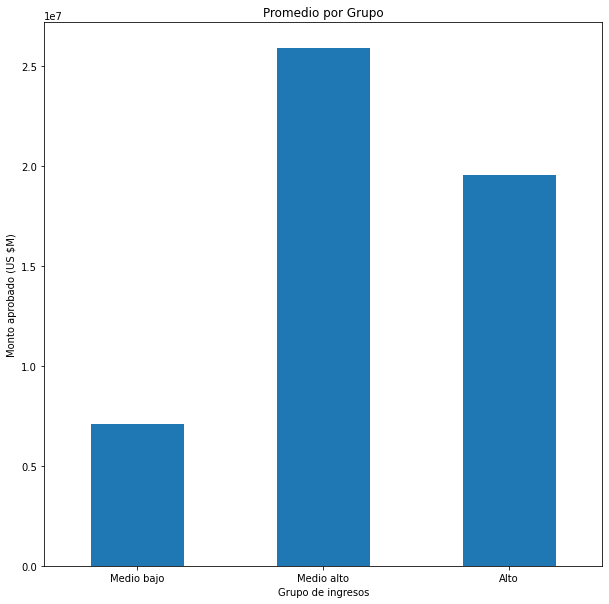

In [767]:
ax = projects_income.groupby('Income_Group')['approval_amount_(us_$m)'].mean()[['Medio bajo', 'Medio alto', 'Alto']].plot.bar(rot=0, figsize=(10,10))
ax.set_ylabel('Monto aprobado (US $M)')
ax.set_xlabel('Grupo de ingresos')
plt.title('Promedio por Grupo')
plt.show()

In [768]:
corrupt

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
0,Aruba,ABW,"Calificación de transparencia, responsabilidad...",IQ.CPA.TRAN.XQ,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afganistán,AFG,"Calificación de transparencia, responsabilidad...",IQ.CPA.TRAN.XQ,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,NaN
2,Angola,AGO,"Calificación de transparencia, responsabilidad...",IQ.CPA.TRAN.XQ,NaN,NaN,NaN,NaN,NaN,NaN,...,2.5,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Albania,ALB,"Calificación de transparencia, responsabilidad...",IQ.CPA.TRAN.XQ,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Andorra,AND,"Calificación de transparencia, responsabilidad...",IQ.CPA.TRAN.XQ,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,Kosovo,XKX,"Calificación de transparencia, responsabilidad...",IQ.CPA.TRAN.XQ,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,NaN,NaN
260,"Yemen, Rep. del",YEM,"Calificación de transparencia, responsabilidad...",IQ.CPA.TRAN.XQ,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,2.0,2.0,1.5,1.5,1.5,1.5,1.5,NaN,NaN
261,Sudáfrica,ZAF,"Calificación de transparencia, responsabilidad...",IQ.CPA.TRAN.XQ,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
262,Zambia,ZMB,"Calificación de transparencia, responsabilidad...",IQ.CPA.TRAN.XQ,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,3.0,3.0,3.0,3.0,3.0,2.5,2.5,NaN,NaN


In [769]:
corrupt_la = corrupt[corrupt['Country Name'].isin(projects.country.unique())]
corrupt_la = corrupt_la[['Country Name',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019', '2020']]
corrupt_la = corrupt_la.melt(id_vars='Country Name', var_name='year', value_name='corruption')
corrupt_la['year'] = corrupt_la['year'].astype(int)
corrupt_la = corrupt_la.query('year > 2014').groupby('Country Name')[['corruption']].mean()

In [770]:
corrupt_la

,corruption
Country Name,
Argentina,NaN
Bahamas,NaN
Barbados,NaN
Bolivia,3.0
Chile,NaN
Colombia,NaN
Costa Rica,NaN
Ecuador,NaN
El Salvador,NaN


In [771]:
gini_la = gini[gini['Country Name'].isin(projects.country.unique())]
gini_la = gini_la[['Country Name',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019', '2020']]
gini_la = gini_la.melt(id_vars='Country Name', var_name='year', value_name='gini')
gini_la['year'] = gini_la['year'].astype(int)
gini_la = gini_la.query('year > 2014').groupby('Country Name')[['gini']].mean()

In [772]:
gini_la

,gini
Country Name,
Argentina,41.533333
Bahamas,NaN
Barbados,NaN
Bolivia,44.375000
Chile,44.400000
Colombia,50.500000
Costa Rica,48.350000
Ecuador,45.275000
El Salvador,39.300000


In [773]:
pbi_la = pbi[pbi['Country Name'].isin(projects.country.unique())]
pbi_la = pbi_la[['Country Name',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019', '2020']]
pbi_la = pbi_la.melt(id_vars='Country Name', var_name='year', value_name='pbi')
pbi_la['year'] = pbi_la['year'].astype(int)
pbi_la = pbi_la.query('year > 2014').groupby('Country Name')[['pbi']].mean()

In [774]:
pbi_la

,pbi
Country Name,
Argentina,5.517962e+11
Bahamas,1.254618e+10
Barbados,4.963700e+09
Bolivia,3.712659e+10
Chile,2.703961e+11
Colombia,3.090751e+11
Costa Rica,5.855423e+10
Ecuador,1.037043e+11
El Salvador,2.514978e+10


In [775]:
country_inds = pd.concat([pbi_la, gini_la, corrupt_la], axis=1)


projects_country_inds = projects_income.merge(country_inds, left_on='country',
               right_index=True)

In [776]:
projects_country_inds

,number,title,description,operation_type,country,sector,approval_amount_(us_$m),approval_date,status,esg_classification,urls,approval_datetime,approval_year,Country Name,Income_Group,pbi,gini,corruption
0,BO-L1202,Improvement Program for Municipal Management II,Support the improvement of municipal cadaster ...,Loan Operation,Bolivia,REFORM / MODERNIZATION OF THE STATE,40000000,NaN,Preparation,C,https://www.iadb.org/project/BO-L1202,NaT,NaN,Bolivia,Medio bajo,3.712659e+10,44.375,3.0
1,BO-T1333,Support to the Preparation of the Program for ...,The objective of this Technical Cooperation (T...,Technical Cooperation,Bolivia,REFORM / MODERNIZATION OF THE STATE,250000,14-Nov-2019,Implementation,C,https://www.iadb.org/project/BO-T1333,2019-11-14,2019.0,Bolivia,Medio bajo,3.712659e+10,44.375,3.0
2,BO-T1334,Support to the Implementation of Electronic Bi...,Assist the National Tax Service in the impleme...,Technical Cooperation,Bolivia,REFORM / MODERNIZATION OF THE STATE,150000,25-Jul-2019,Implementation,C,https://www.iadb.org/project/BO-T1334,2019-07-25,2019.0,Bolivia,Medio bajo,3.712659e+10,44.375,3.0
3,BO-L1111,Program to Support Pre-Investment for Developm...,The general objective of the program is to imp...,Loan Operation,Bolivia,REFORM / MODERNIZATION OF THE STATE,15000000,12-Dec-2018,Cancelled,B13,https://www.iadb.org/project/BO-L1111,2018-12-12,2018.0,Bolivia,Medio bajo,3.712659e+10,44.375,3.0
4,BO-T1315,Support to the Sustainability of Public Invest...,The objective of this technical cooperation wi...,Technical Cooperation,Bolivia,REFORM / MODERNIZATION OF THE STATE,200000,14-Sep-2018,Implementation,C,https://www.iadb.org/project/BO-T1315,2018-09-14,2018.0,Bolivia,Medio bajo,3.712659e+10,44.375,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1821,TC8304149,"Preparation, National Plan of Investment",EN,Technical Cooperation,Guatemala,REFORM / MODERNIZATION OF THE STATE,90000,25-Feb-1983,Closed,NaN,https://www.iadb.org/project/TC8304149,1983-02-25,1983.0,Guatemala,Medio alto,6.993615e+10,NaN,NaN
1822,TC8208094,National Plan for Public Investments,NaN,Technical Cooperation,Guatemala,REFORM / MODERNIZATION OF THE STATE,20000,21-Dec-1982,Closed,NaN,https://www.iadb.org/project/TC8208094,1982-12-21,1982.0,Guatemala,Medio alto,6.993615e+10,NaN,NaN
1823,TC7612337,Brasil Preinvestment Cooperation,EN,Technical Cooperation,Guatemala,REFORM / MODERNIZATION OF THE STATE,10000,29-Dec-1976,Closed,NaN,https://www.iadb.org/project/TC7612337,1976-12-29,1976.0,Guatemala,Medio alto,6.993615e+10,NaN,NaN
1824,TC7511042,Creation of Unity Project,EN,Technical Cooperation,Guatemala,REFORM / MODERNIZATION OF THE STATE,240000,11-Dec-1975,Closed,NaN,https://www.iadb.org/project/TC7511042,1975-12-11,1975.0,Guatemala,Medio alto,6.993615e+10,NaN,NaN


In [778]:
subset = (projects_country_inds
    .query('status == "Closed"')
    .query('2020 > approval_year > 2014'))

In [781]:
subset[['number', 'operation_type', 'country', 'sector',
       'approval_amount_(us_$m)', 
       'esg_classification', 
       'Income_Group', 'pbi', 'gini', 'corruption']][subset['number'].str.startswith('AR-L')]

,number,operation_type,country,sector,approval_amount_(us_$m),esg_classification,Income_Group,pbi,gini,corruption
1221,AR-L1303,Loan Operation,Argentina,REFORM / MODERNIZATION OF THE STATE,200000000,B13,Medio alto,5.517962e+11,41.533333,NaN
1223,AR-L1304,Loan Operation,Argentina,REFORM / MODERNIZATION OF THE STATE,300000000,B13,Medio alto,5.517962e+11,41.533333,NaN
1225,AR-L1283,Loan Operation,Argentina,REFORM / MODERNIZATION OF THE STATE,300000000,B13,Medio alto,5.517962e+11,41.533333,NaN
1231,AR-L1268,Loan Operation,Argentina,REFORM / MODERNIZATION OF THE STATE,200000000,B13,Medio alto,5.517962e+11,41.533333,NaN


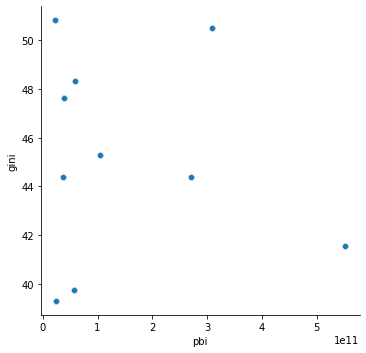

In [782]:
sns.relplot(data=projects_country_inds, x='pbi', y='gini')

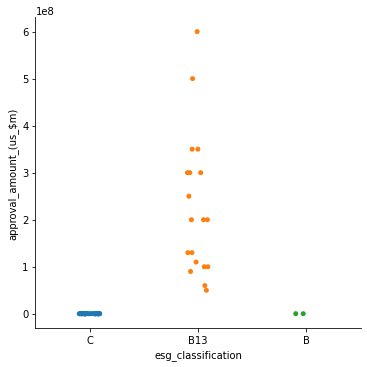

In [783]:
sns.catplot(data=subset, x='esg_classification', y='approval_amount_(us_$m)')

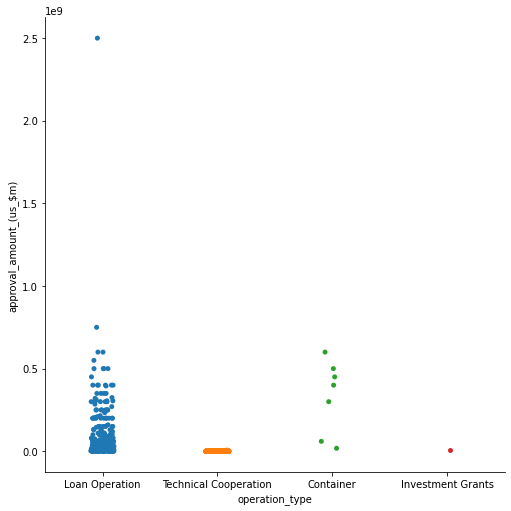

In [788]:
sns.catplot(data=projects_country_inds, x='operation_type', y='approval_amount_(us_$m)', height=7)

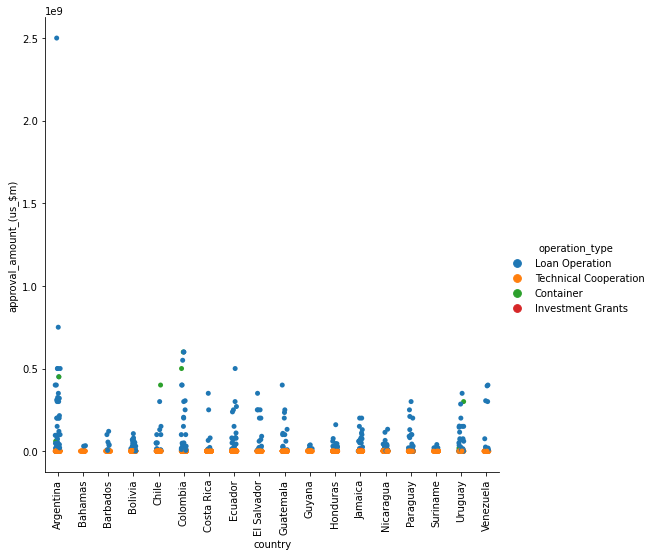

In [785]:
g = sns.catplot(data=projects_country_inds.sort_values("country"), x='country',
                y='approval_amount_(us_$m)',
                hue='operation_type', height=7)
g.set_xticklabels(rotation=90)

/Users/claudio/Documents/bid-projects-ranking/.env/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 26.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/claudio/Documents/bid-projects-ranking/.env/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 31.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/claudio/Documents/bid-projects-ranking/.env/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 89.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/claudio/Documents/bid-projects-ranking/.env/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 77.5% of the points cannot be placed; you may want to decrease the size of the markers or use strip

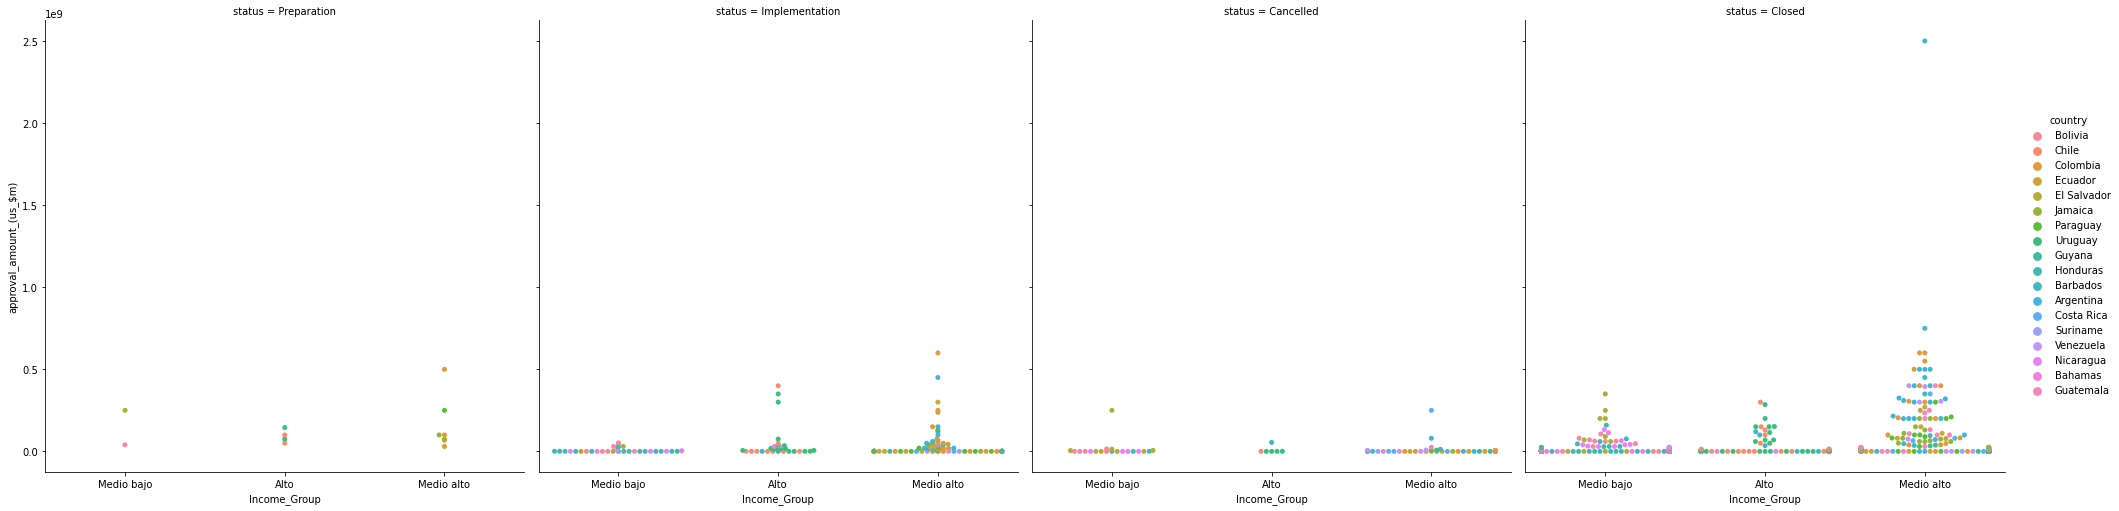

In [789]:
sns.catplot(x="Income_Group", y="approval_amount_(us_$m)", hue="country",
            col="status", height=7,
            kind="swarm", data=projects_country_inds)